In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import edge_sim_py as espy
import networkx as nx

In [3]:
headers = [
    "Radio",  # The generation of broadband cellular network technology (Eg. LTE, GSM)
    "MCC",  # Mobile country code. This info is publicly shared by International Telecommunication Union (link)
    "MNC",  # Mobile network code. This info is publicly shared by International Telecommunication Union (link)
    "LAC/TAC/NID",  # Location Area Code
    "CID",  # This is a unique number used to identify each Base transceiver station or sector of BTS
    "Changeable=0",  # The location is directly obtained from the telecom firm
    "Longitude",  # Longitude, is a geographic coordinate that specifies the east-west position of a point on the Earth's surface
    "Latitude",  # Latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface.
    "Range",  # Approximate area within which the cell could be. (In meters)
    "Samples",  # Number of measures processed to get a particular data point
    "Changeable=1",  # The location is determined by processing samples
    "Created",  # When a particular cell was first added to database (UNIX timestamp)
    "Updated",  # When a particular cell was last seen (UNIX timestamp)
    "AverageSignal",  # To get the positions of cells, OpenCelliD processes measurements from data contributors. Each measurement includes GPS location of device + Scanned cell identifier (MCC-MNC-LAC-CID) + Other device properties (Signal strength). In this process, signal strength of the device is averaged. Most ‘averageSignal’ values are 0 because OpenCelliD simply didn’t receive signal strength values.
]
df_og = pd.read_csv("../datasets/geo-dataset-724.csv", names=headers)  # , usecols=[4, 6, 7, 8])
df_og

,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,5,2151,15463,0,-51.195946,-30.073872,1000,8,1,1459732112,1492009233,0
1,GSM,724,5,332,46623,0,-44.217924,-21.120660,1000,2,1,1459786828,1505328390,0
2,GSM,724,5,849,50103,0,-50.560883,-27.313627,1571,2,1,1459813079,1505870447,0
3,GSM,724,5,3411,20511,0,-46.844001,-23.560824,2109,132,1,1459743036,1506015757,0
4,GSM,724,6,5066,32801,0,-55.523680,-11.794043,2724,5,1,1459703160,1494337597,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863125,LTE,724,10,51211,204808499,-1,-47.130093,-22.801365,1000,1,1,1695099545,1695099545,0
1863126,LTE,724,10,51211,205085451,-1,-46.791988,-23.516623,1000,1,1,1695099675,1695099675,0
1863127,LTE,724,10,51211,204809238,-1,-46.791988,-23.516623,1000,1,1,1695100405,1695100405,0
1863128,LTE,724,10,50211,207449908,-1,-46.791988,-23.516623,1000,1,1,1695100727,1695100727,0


In [4]:
df_og.dtypes

Radio             object
MCC                int64
MNC                int64
LAC/TAC/NID        int64
CID                int64
Changeable=0       int64
Longitude        float64
Latitude         float64
Range              int64
Samples            int64
Changeable=1       int64
Created            int64
Updated            int64
AverageSignal      int64
dtype: object

In [5]:
# ---------------
# | 0,0       0,1
# |
# | 1,0       1,1
# ---------------
# Latitude, Longitude (x, y)
# ---------------
# | +1,-1   +1,+0   +1,+1
# |
# | +0,-1   +0,+0   +1,+0
# |
# | -1,-1   -1,+0   +1,-1
# ---------------
# São Paulo
coord_start = { "Latitude": -23.438893, "Longitude": -46.324440 }
coord_final = { "Latitude": -23.814428, "Longitude": -46.911431 }

# Joinville
coord_start = { "Latitude": -26.200431, "Longitude": -48.748822 }
coord_final = { "Latitude": -26.376193, "Longitude": -48.945546 }

df = df_og.copy()

df = df.loc[df.Latitude <= coord_start["Latitude"]]
df = df.loc[df.Longitude <= coord_start["Longitude"]]

df = df.loc[df.Latitude >= coord_final["Latitude"]]
df = df.loc[df.Longitude >= coord_final["Longitude"]]

df = df.reset_index(drop=True)
df

,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,16,4701,1682,0,-48.795090,-26.282730,1000,5,1,1223561212,1223561212,0
1,GSM,724,16,4701,1468,0,-48.799687,-26.268251,1674,46,1,1223580558,1239201914,0
2,GSM,724,16,4701,1593,0,-48.812587,-26.269779,2262,116,1,1223580558,1239201917,0
3,GSM,724,16,4701,591,0,-48.848158,-26.290970,1000,14,1,1223560849,1223560849,0
4,GSM,724,16,4701,593,0,-48.848373,-26.290970,1000,5,1,1223560849,1223560849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854,GSM,724,4,27947,26003,-1,-48.853757,-26.301949,1000,21,1,1690729390,1690729777,0
4855,GSM,724,4,27947,26142,-1,-48.853557,-26.300305,1000,4,1,1690729404,1690729407,0
4856,GSM,724,5,1547,10465,-1,-48.841338,-26.333559,1000,24,1,1691003522,1691008395,0
4857,GSM,724,5,1547,10665,-1,-48.841034,-26.333214,500,127,1,1691003536,1692280817,0


In [6]:
df_norm = df.copy()
lower, upper = 0, 100_000

lat_min, lat_max = df_norm.Latitude.min(), df_norm.Latitude.max()
df_norm.Latitude = (df_norm.Latitude - lat_min) / (lat_max - lat_min) * (upper - lower) + lower
df_norm.Latitude = df_norm.Latitude.astype(np.int64)

lon_min, lon_max = df_norm.Longitude.min(), df_norm.Longitude.max()
df_norm.Longitude = (df_norm.Longitude - lon_min) / (lon_max - lon_min) * (upper - lower) + lower
df_norm.Longitude = df_norm.Longitude.astype(np.int64)

print(df_norm[['Latitude', 'Longitude']].value_counts())

df_norm

Latitude  Longitude
50837     45092        11
34413     45805         6
38323     50797         5
41452     48658         5
59440     36535         5
                       ..
37596     52619         1
37608     50495         1
37666     10601         1
37687     60054         1
100000    18620         1
Length: 4599, dtype: int64


,Radio,MCC,MNC,LAC/TAC/NID,CID,Changeable=0,Longitude,Latitude,Range,Samples,Changeable=1,Created,Updated,AverageSignal
0,GSM,724,16,4701,1682,0,77894,53183,1000,5,1,1223561212,1223561212,0
1,GSM,724,16,4701,1468,0,75507,61429,1674,46,1,1223580558,1239201914,0
2,GSM,724,16,4701,1593,0,68808,60559,2262,116,1,1223580558,1239201917,0
3,GSM,724,16,4701,591,0,50338,48491,1000,14,1,1223560849,1223560849,0
4,GSM,724,16,4701,593,0,50227,48491,1000,5,1,1223560849,1223560849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854,GSM,724,4,27947,26003,-1,47431,42238,1000,21,1,1690729390,1690729777,0
4855,GSM,724,4,27947,26142,-1,47535,43174,1000,4,1,1690729404,1690729407,0
4856,GSM,724,5,1547,10465,-1,53880,24235,1000,24,1,1691003522,1691008395,0
4857,GSM,724,5,1547,10665,-1,54037,24432,500,127,1,1691003536,1692280817,0


In [7]:
# plt.plot(df_norm.Latitude, df_norm.Longitude, 'ro')
# plt.show()

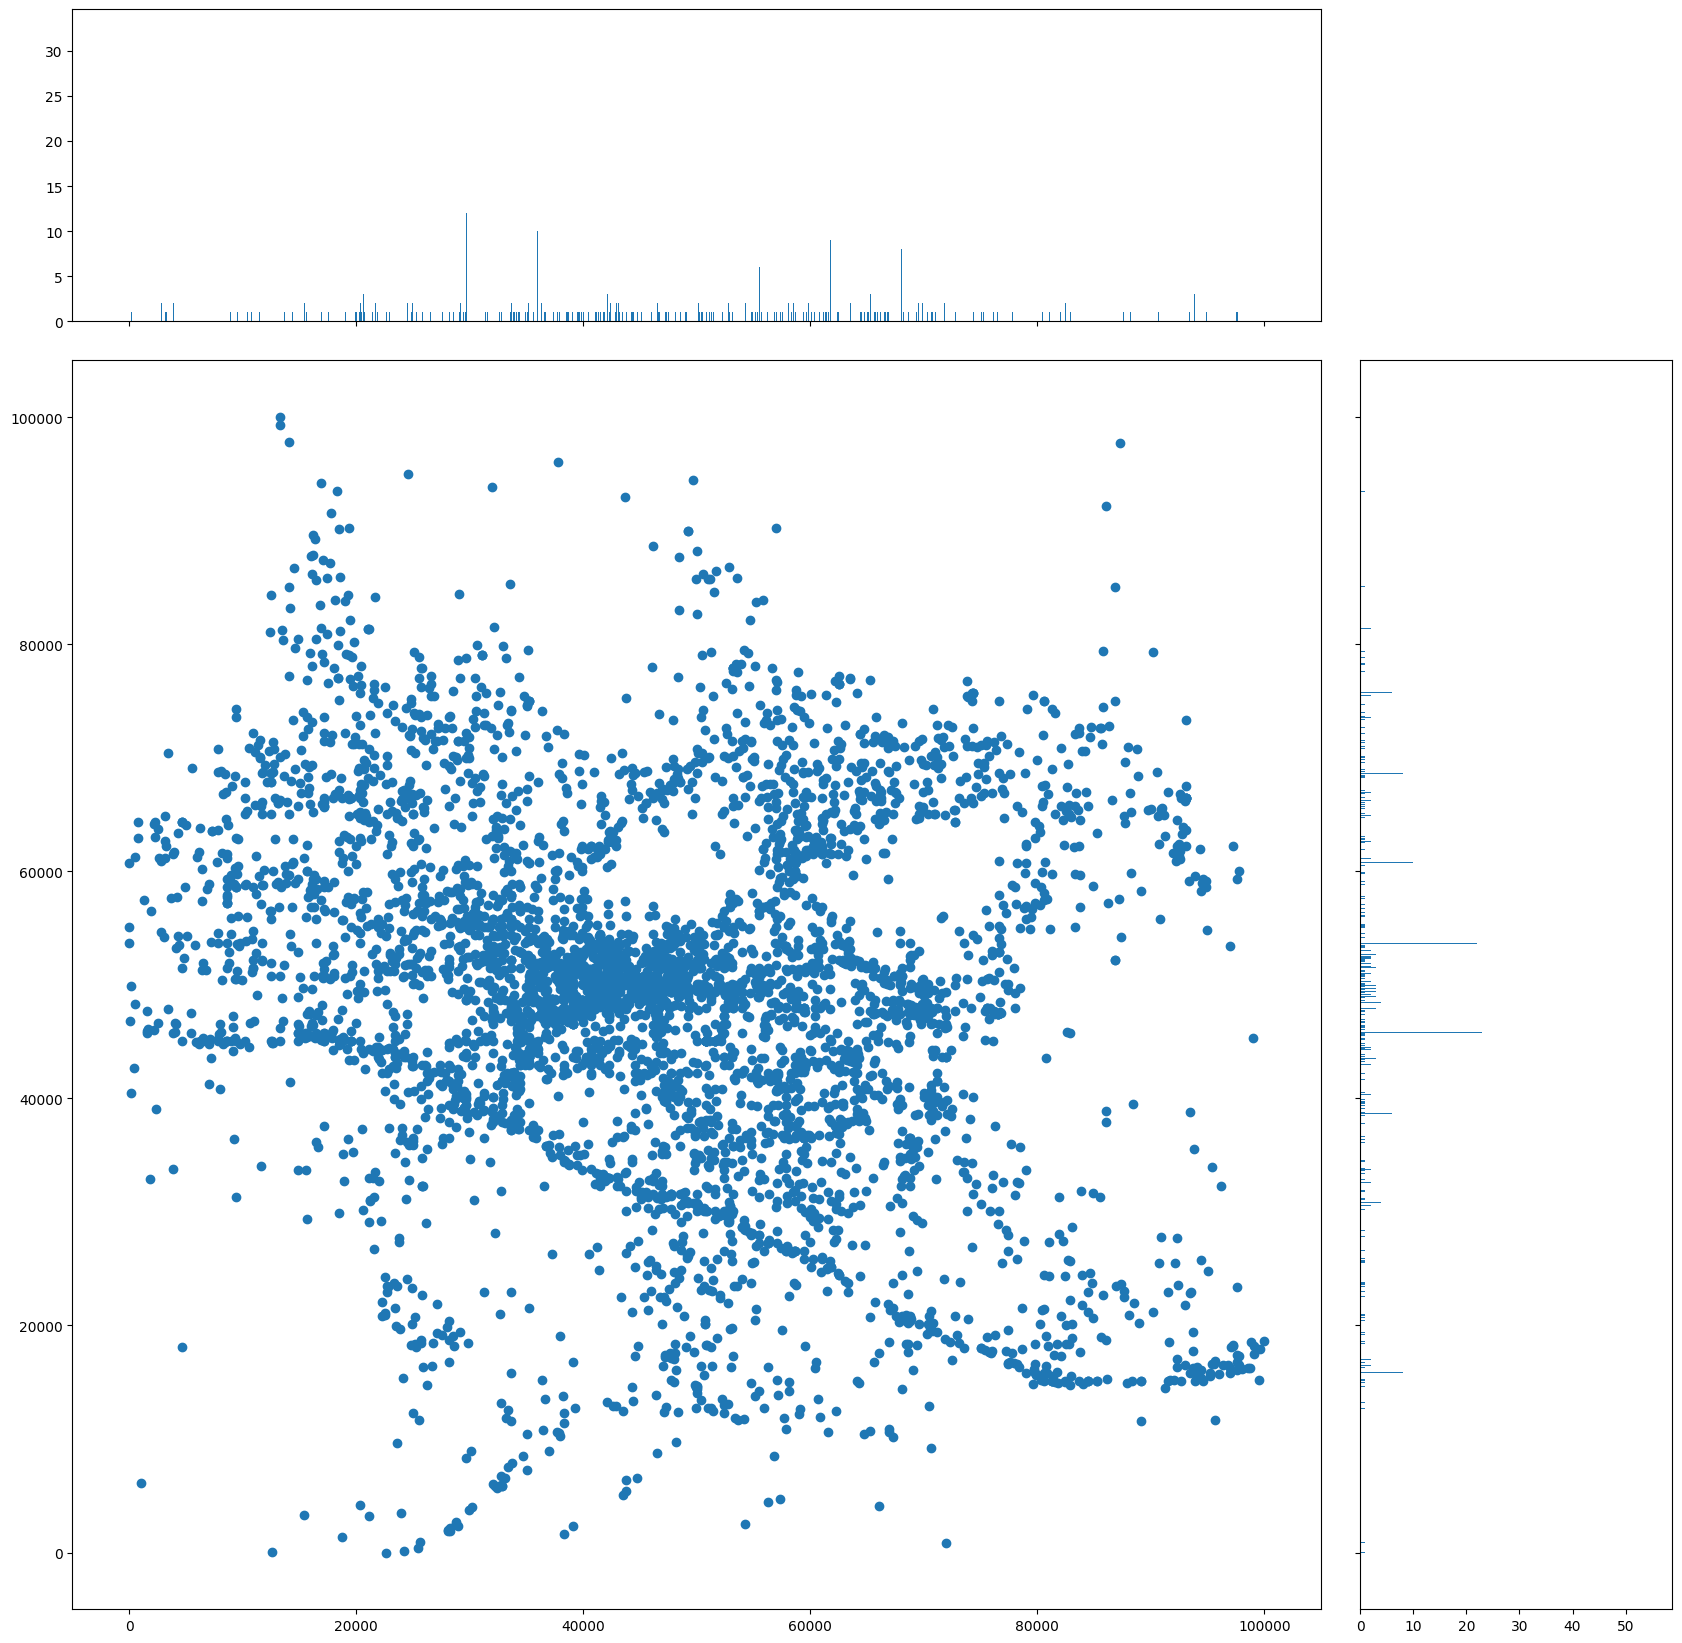

In [8]:
x, y = df_norm.Latitude.copy(), df_norm.Longitude.copy()

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 5
    lim = (int(upper/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

# Start with a square Figure.
fig = plt.figure(figsize=(20, 20))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)

In [9]:
def my_algorithm(parameters):
    # We can always call the 'all()' method to get a list with all created instances of a given class
    for service in espy.Service.all():
        # We don't want to migrate services are are already being migrated
        if service.server == None and not service.being_provisioned:
            # Let's iterate over the list of edge servers to find a suitable host for our service
            for edge_server in espy.EdgeServer.all():
                # We must check if the edge server has enough resources to host the service
                if edge_server.has_capacity_to_host(service=service):
                    # Start provisioning the service in the edge server
                    service.provision(target_server=edge_server)
                    # After start migrating the service we can move on to the next service
                    break


def stopping_criterion(model: object):
    # Defining a variable that will help us to count the number of services successfully provisioned within the infrastructure
    provisioned_services = 0
    # Iterating over the list of services to count the number of services provisioned within the infrastructure
    for service in espy.Service.all():
        # Initially, services are not hosted by any server (i.e., their "server" attribute is None).
        # Once that value changes, we know that it has been successfully provisioned inside an edge server.
        if service.server != None:
            provisioned_services += 1
    # As EdgeSimPy will halt the simulation whenever this function returns True, its output will be a boolean expression
    # that checks if the number of provisioned services equals to the number of services spawned in our simulation
    return provisioned_services == espy.Service.count()

In [ ]:
simulator = espy.Simulator(
    dump_interval=5,
    tick_duration=1,
    tick_unit="seconds",
    stopping_criterion=stopping_criterion,
    resource_management_algorithm=my_algorithm,

)

simulator.initialize_agent()

G = nx.Graph()
espy.Topology(existing_graph=G).add_node